In [1]:
import os
os.chdir(path='../')
import scanpy as sc
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import STForte.helper as stfhelper
from STForte import STForteModel
from STForte.helper import mclust_R
from plotly.subplots import make_subplots
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=24)
trial_name = "trial-Visium_FFPE_Human_Prostate_Cancer"
data_name = "Visium_FFPE_Human_Prostate_Cancer"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
palette = px.colors.qualitative.Plotly

/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 0


In [2]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
adata

AnnData object with n_obs × n_vars = 4371 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'STForte_Mask', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [3]:
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata_sp

AnnData object with n_obs × n_vars = 17040 × 300
    obs: 'spot_instance', 'leiden_with_padding'
    uns: 'leiden_with_padding_colors', 'neighbors', 'umap'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'X_umap', 'spatial'
    obsp: 'A_STForte_conn', 'A_STForte_recon', 'connectivities', 'distances'

In [4]:
model = STForteModel.__load_from_saved_model__(f"./{trial_name}/models/STForteModel_{trial_name}")
model

In [5]:
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.pp.neighbors(adata, use_rep=f"{key}", key_added=f"CONN_{key}")
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.tl.leiden(adata, key_added=f"leiden_{key}", neighbors_key=f"CONN_{key}", resolution=0.3)
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    adata.obsm[f"{key}_umap"] = sc.tl.umap(adata, neighbors_key=f"CONN_{key}", copy=True).obsm['X_umap']

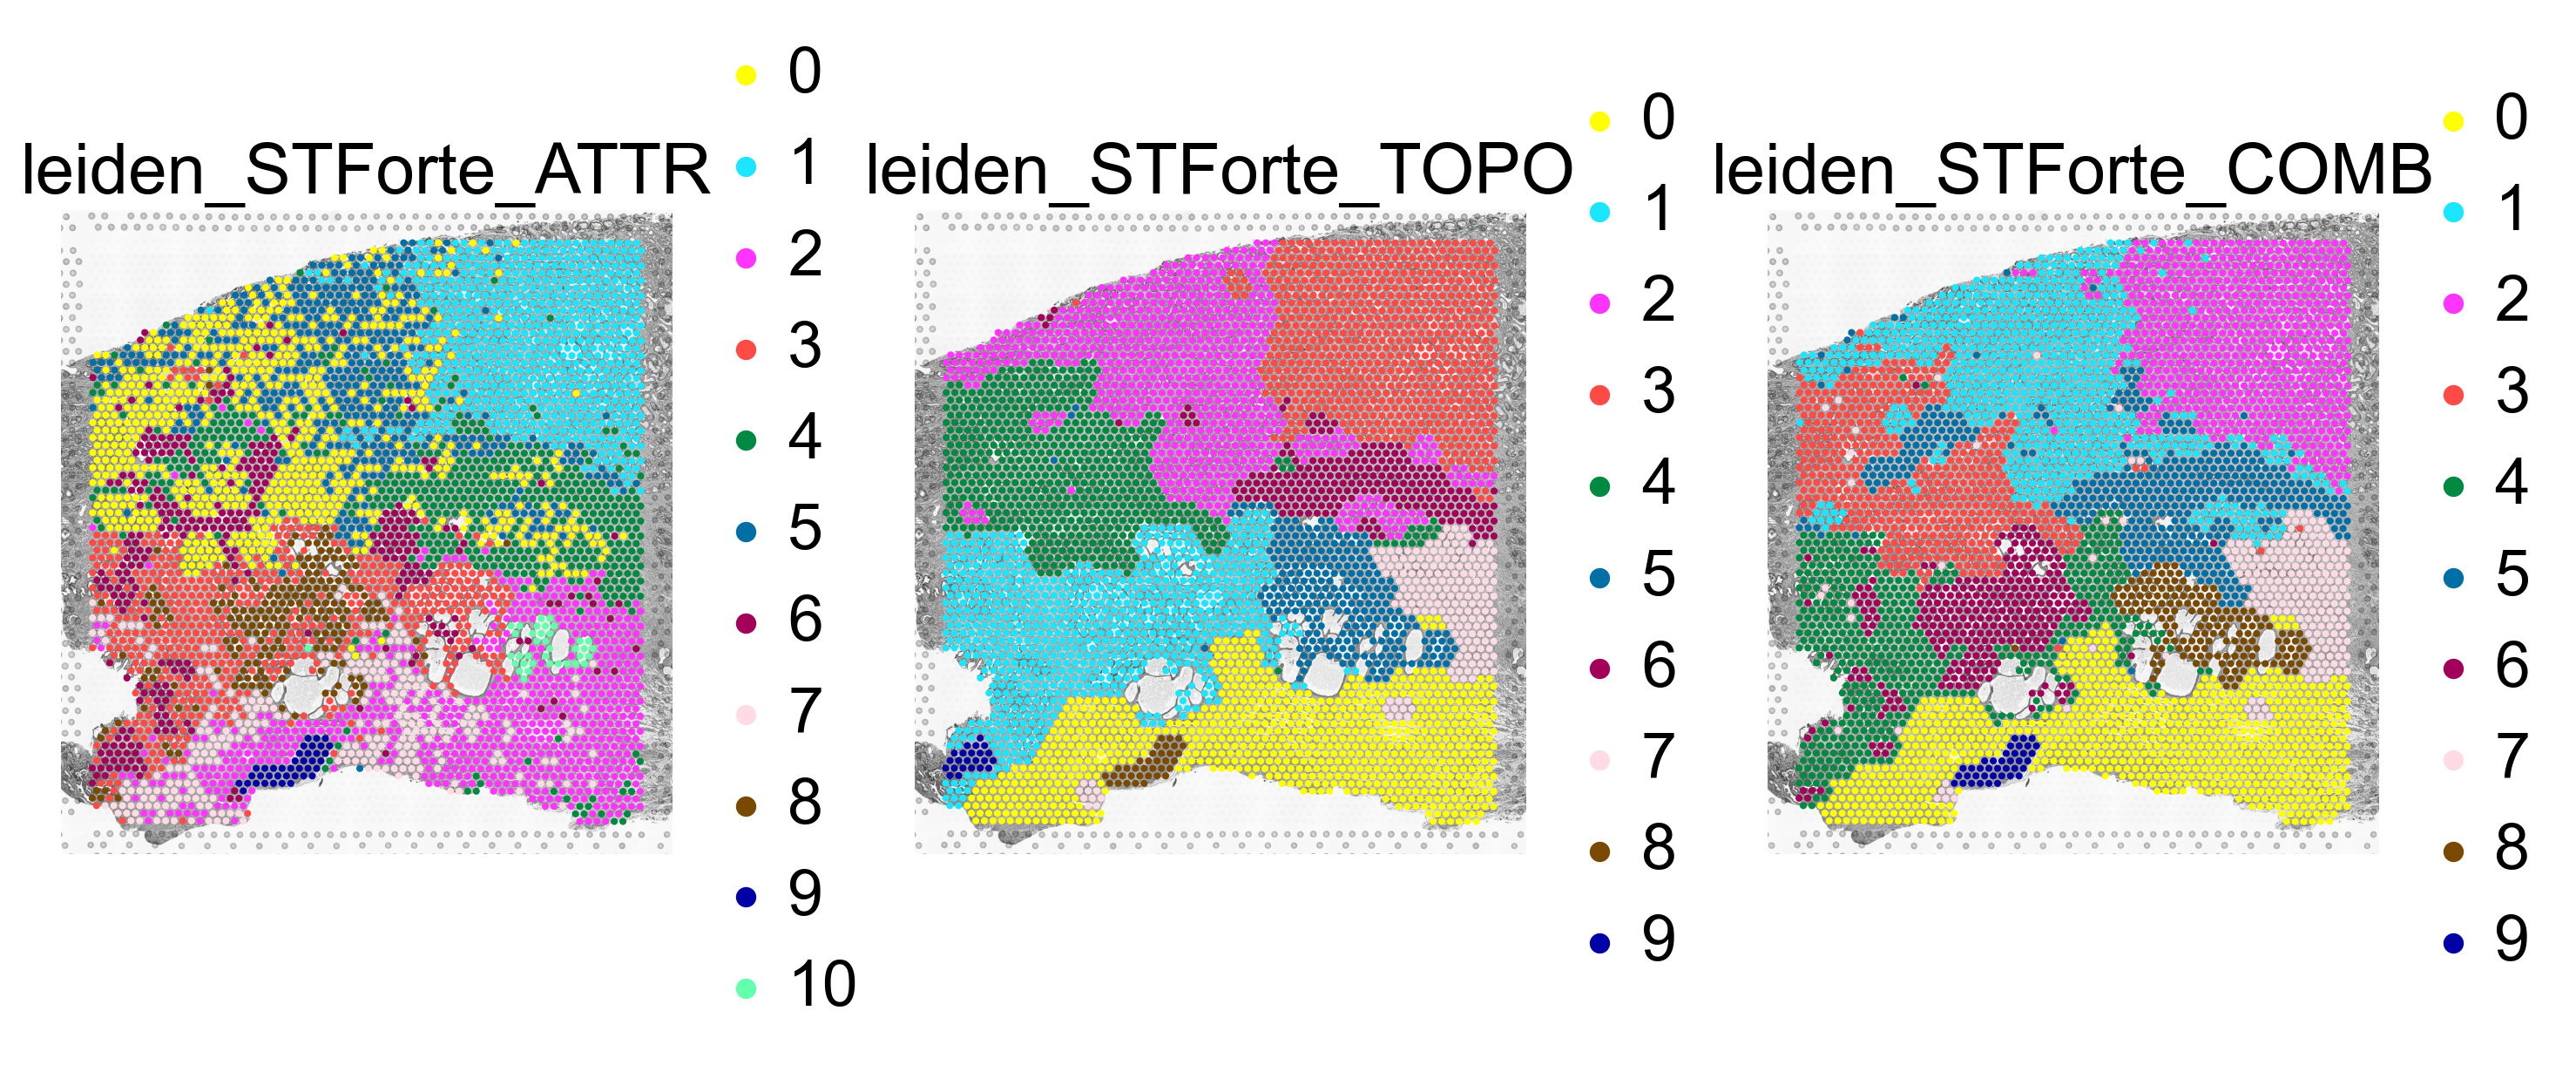

In [6]:
sc.pl.spatial(adata, color=["leiden_STForte_ATTR", "leiden_STForte_TOPO", "leiden_STForte_COMB"], img_key="hires", bw=True, size=1.25, frameon=False,
              palette=stfhelper.pl.godsnot_102,
              save="_leiden_compare",
              )

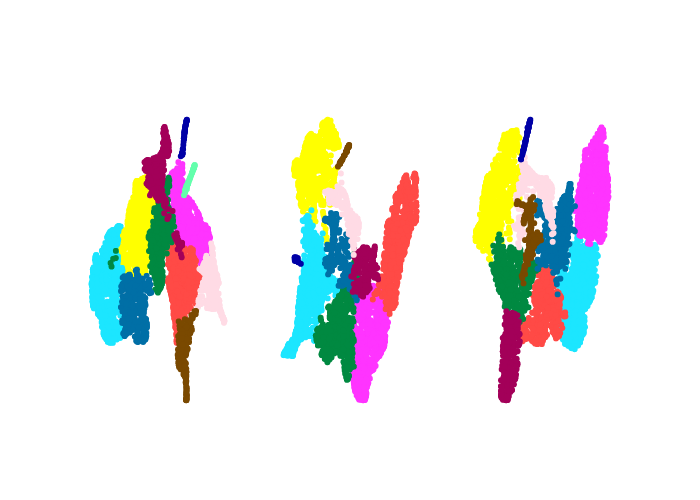

In [7]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]):
    for jj, cc in enumerate(adata.obs[f"leiden_{key}"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata[adata.obs[f"leiden_{key}"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata[adata.obs[f"leiden_{key}"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=adata.uns[f'leiden_{key}_colors'][jj]
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", showlegend=False)
fig.write_image(f"{plot_dir}/umap_leiden_compare.pdf", width=1200, height=400)
fig.show(renderer="png")

In [8]:
base_label = "STForte_ATTR"
for key in ["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]:
    adata_sp.obs[f"leiden_{base_label}_pad_{key}"] = stfhelper.annotation_propagate(adata_sp, f"leiden_{base_label}", adata, latent_embed=key, copy=True)

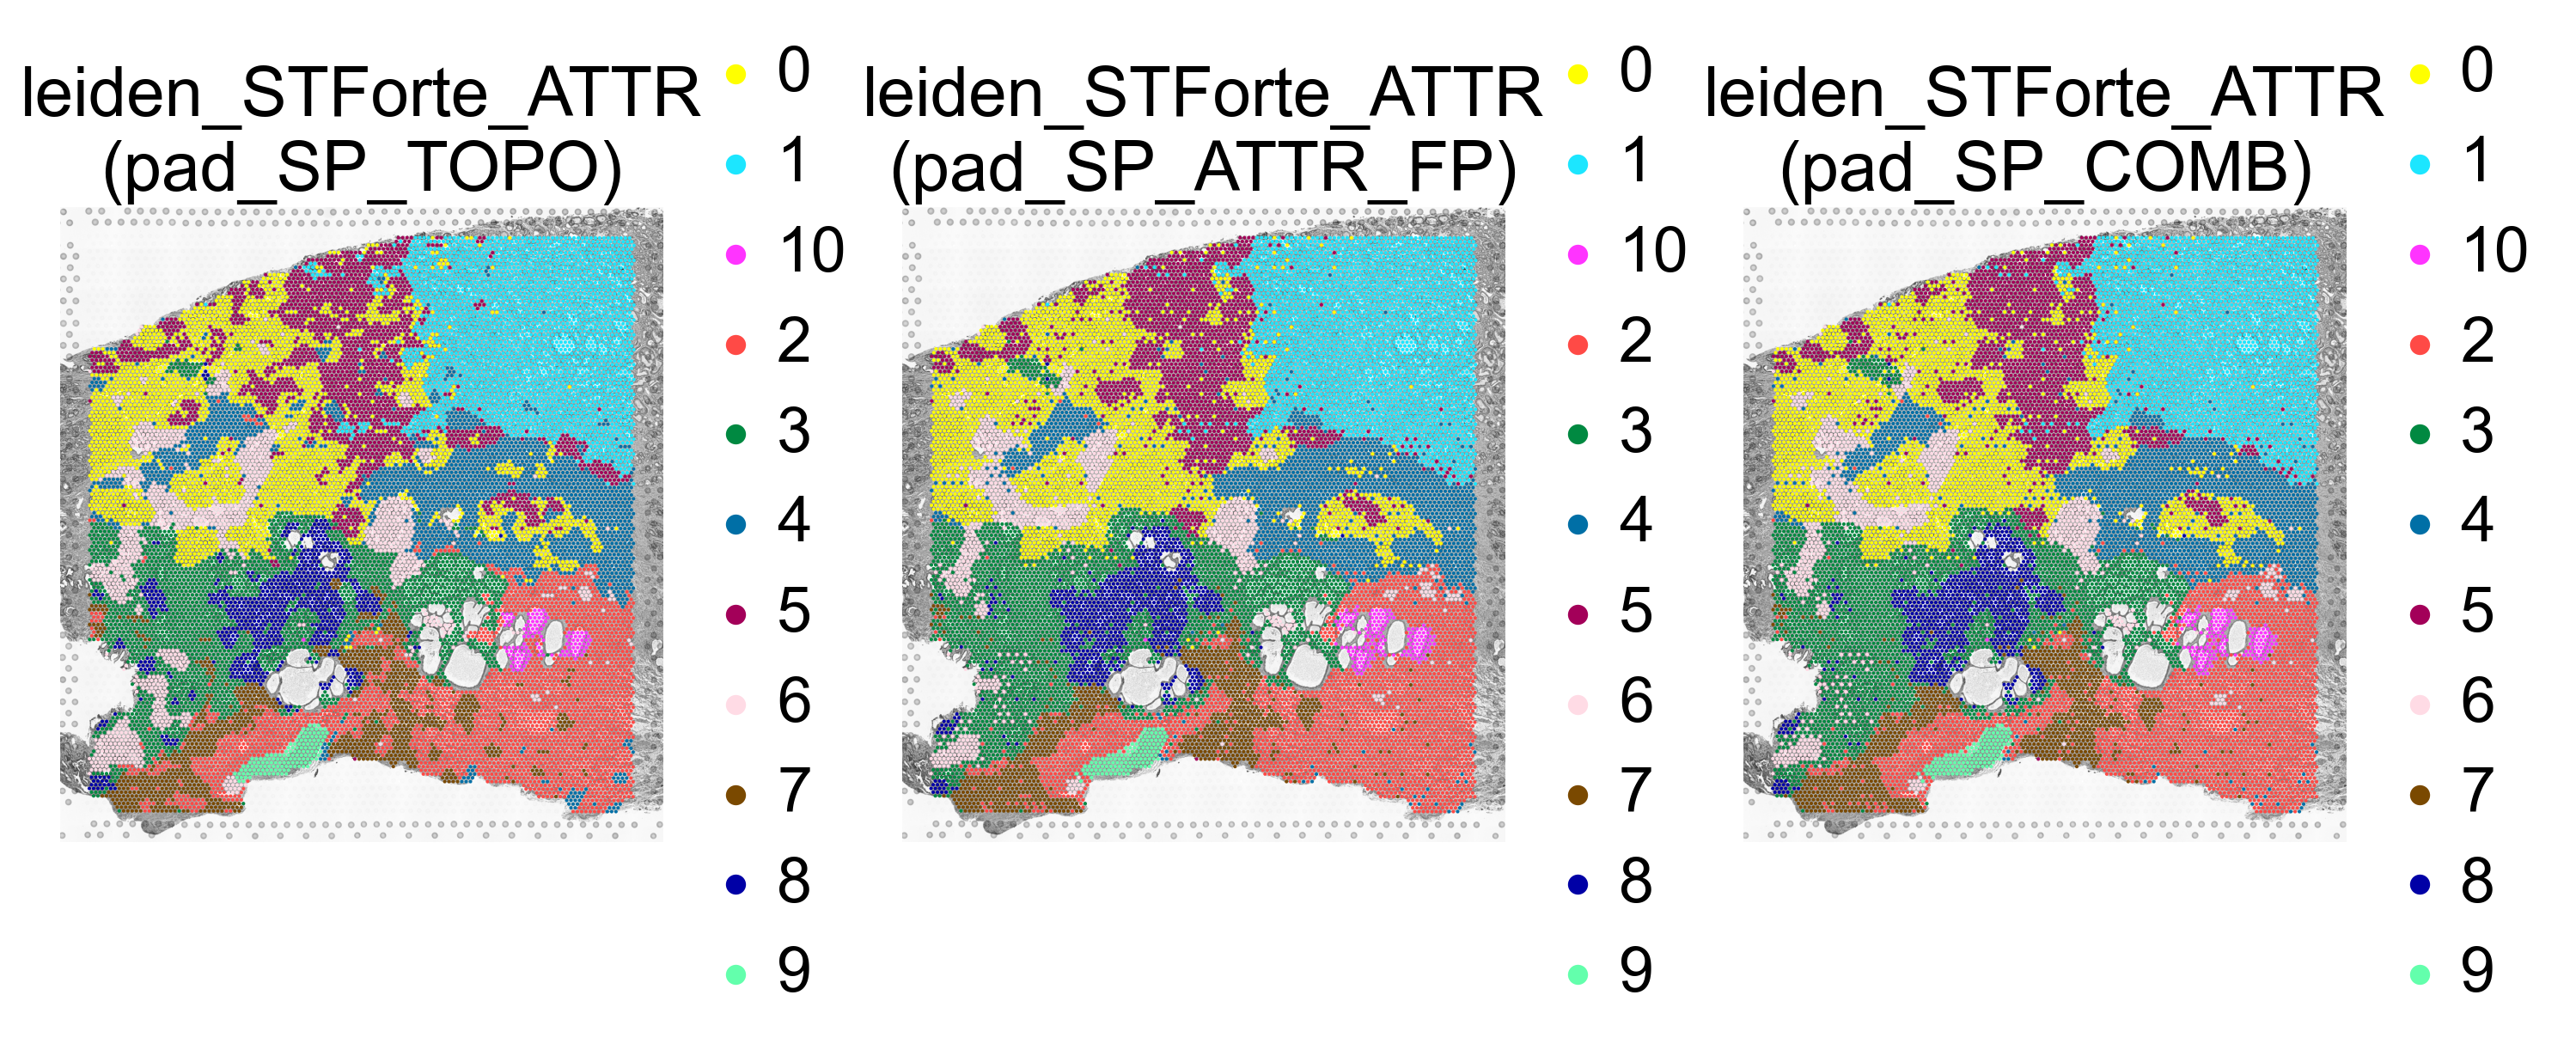

In [9]:
sc.pl.spatial(adata_sp, size=0.625, bw=True,
              color=[f'leiden_{base_label}_pad_SP_TOPO', f'leiden_{base_label}_pad_SP_ATTR_FP', f'leiden_{base_label}_pad_SP_COMB'], 
              title=[f'leiden_{base_label}\n(pad_SP_TOPO)', f'leiden_{base_label}\n(pad_SP_ATTR_FP)', f'leiden_{base_label}\n(pad_SP_COMB)'],
              palette=stfhelper.pl.godsnot_102,
              frameon=False,
              img=adata.uns['spatial'][data_name]['images']['hires'],
              spot_size=adata.uns['spatial'][data_name]['scalefactors']['spot_diameter_fullres'], 
              scale_factor=adata.uns['spatial'][data_name]['scalefactors']['tissue_hires_scalef'],
              save="_leiden_sp_compare"
              )

In [10]:
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    sc.pp.neighbors(adata_sp, use_rep=f"{key}", key_added=f"CONN_{key}")
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    adata_sp.obsm[f"{key}_umap"] = sc.tl.umap(adata_sp, neighbors_key=f"CONN_{key}", copy=True).obsm['X_umap']

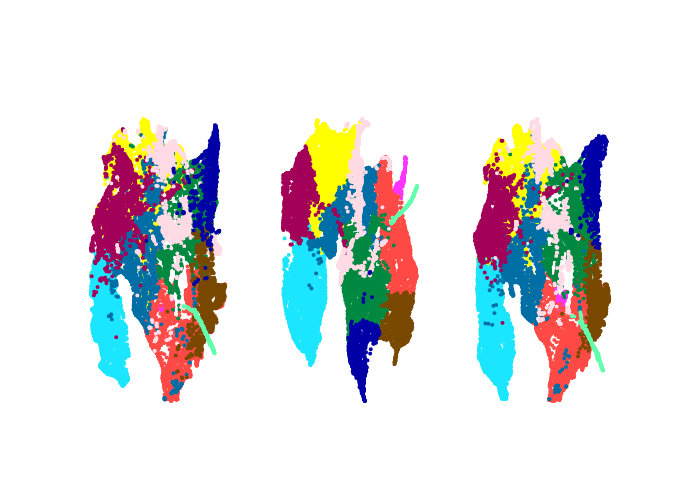

In [11]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    for jj, cc in enumerate(adata_sp.obs[f"leiden_{base_label}_pad_{key}"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata_sp[adata_sp.obs[f"leiden_{base_label}_pad_{key}"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata_sp[adata_sp.obs[f"leiden_{base_label}_pad_{key}"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=adata_sp.uns[f'leiden_{base_label}_pad_{key}_colors'][jj],
                marker_size=4,
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", showlegend=False)
fig.write_image(f"{plot_dir}/umap_sp_pad_compare.pdf", width=1200, height=400)
fig.show(renderer="png")

In [12]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    for jj, cc in enumerate(adata_sp.obs[f"spot_instance"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata_sp[adata_sp.obs[f"spot_instance"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata_sp[adata_sp.obs[f"spot_instance"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=stfhelper.pl.iwanthue_alphabet_hard[jj],
                name=cc,
                marker_size=4,
                showlegend=False if ii != 0 else True,
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", legend=dict(orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=-0.2,
    xanchor="center",
    x=0.5,
    itemsizing='constant'))
fig.write_image(f"{plot_dir}/umap_sp_instance_compare.pdf", width=1200, height=400)
fig.show(renderer="png")